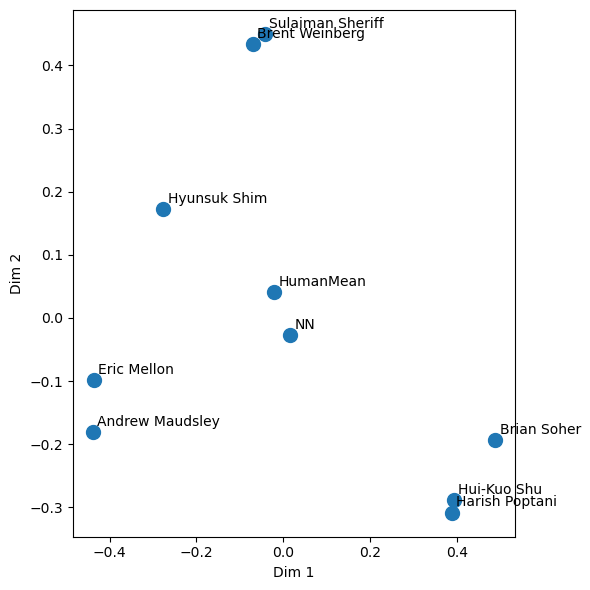

In [4]:
import ast
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# 1) Load your CSV
df = pd.read_csv(r"E:\ArtifactRemovalProject\results\combined_ratings_predictions.csv")
# 2) Parse the list of raters in each row
df['rater_list'] = df['raters'].apply(ast.literal_eval)

# 3) Find all unique human‐rater names
all_raters = sorted({r for sub in df['rater_list'] for r in sub})

# 4) Build an empty “wide” DataFrame
wide = pd.DataFrame(index=df['unique_id'], columns=all_raters + ['NN'], dtype=object)

# 5) Fill in each human rating
for _, row in df.iterrows():
    ratings = [row['rating_1'], row['rating_2'], row['rating_3']]
    for name, rating in zip(row['rater_list'], ratings):
        wide.at[row['unique_id'], name] = rating
    # NN prediction as its own column
    wide.at[row['unique_id'], 'NN'] = row['fits_combined_pred']

# 6) Encode each column as categorical codes
coded = wide.apply(lambda col: col.astype('category').cat.codes)

# 5) Compute our “HumanMean” column: mean of the 3 assigned raters per spectrum
human_cols = all_raters
wide_human_codes = coded[human_cols].replace(-1, np.nan)
human_mean = wide_human_codes.mean(axis=1)       # continuous between code values
coded['HumanMean'] = human_mean

# 6) Recompute distance matrix over all columns (9 raters + 'NN' + 'HumanMean')
names = coded.columns.tolist()   # length = 11
n = coded.shape[1]
dist_matrix = np.zeros((n, n), dtype=float)

for i in range(n):
    # distance to self is zero
    dist_matrix[i, i] = 0.0

    # only compute j > i, then mirror
    for j in range(i+1, n):
        a = coded.iloc[:, i]
        b = coded.iloc[:, j]

        # only compare where both raters actually labeled
        mask = (a != -1) & (b != -1)
        if mask.sum() > 0:
            d = (a[mask] != b[mask]).sum() / mask.sum()
        else:
            # no common ratings → treat as maximally distant
            d = 1            # <-- mark missing here
        dist_matrix[i, j] = dist_matrix[j, i] = d

# after filling dist_matrix with np.nan
mean_d = np.nanmean(dist_matrix)
median_d = np.nanmedian(dist_matrix)
dist_matrix = np.where(np.isnan(dist_matrix), median_d, dist_matrix)

# 7) Run MDS in 2D (to visualize) including the HumanMean point:
mds2 = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords2 = mds2.fit_transform(dist_matrix)

plt.figure(figsize=(6,6))
plt.scatter(coords2[:,0], coords2[:,1], s=100)
for (x,y), lbl in zip(coords2, names):
    plt.text(x+0.01, y+0.01, lbl, fontsize=10)
#plt.title("2D MDS of Raters + HumanMean + NN")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(False)
plt.tight_layout()
plt.show()


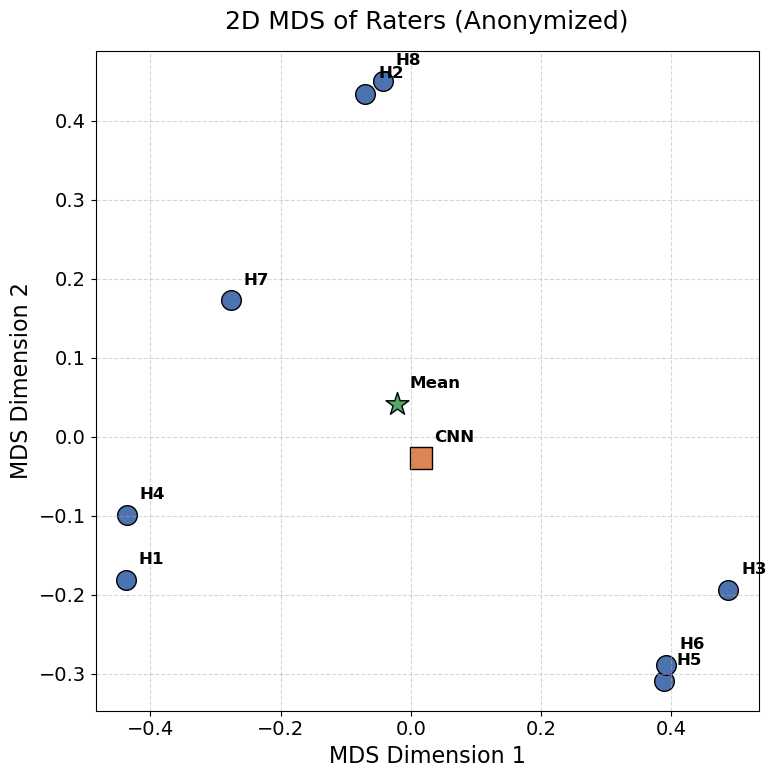

In [5]:
# ─── ANONYMIZE + STYLE MDS PLOT ───────────────────────────────────────────

# 1) Build an anonymization map
anon_map = {r: f"H{i+1}" for i, r in enumerate(all_raters)}    # H1, H2, …
anon_map['NN']       = 'CNN'
anon_map['HumanMean']= 'Mean'

names       = coded.columns.tolist()
anon_labels = [anon_map[name] for name in names]

# 2) Split out indices for styling
human_idx = [i for i, n in enumerate(names) if n in all_raters]
cnn_idx   = names.index('NN')
mean_idx  = names.index('HumanMean')

# 3) Configure global styling
plt.rcParams.update({
    'figure.figsize':   (8, 8),
    'font.size':        14,
    'axes.titlesize':   18,
    'axes.labelsize':   16,
    'xtick.labelsize':  14,
    'ytick.labelsize':  14,
})

fig, ax = plt.subplots()

# 4) Plot each group with its own marker/color
ax.scatter(coords2[human_idx,0], coords2[human_idx,1],
           s=200, marker='o', edgecolor='black', facecolor='#4C72B0', label='Humans')
ax.scatter(coords2[cnn_idx,0],   coords2[cnn_idx,1],
           s=250, marker='s', edgecolor='black', facecolor='#DD8452', label='CNN')
ax.scatter(coords2[mean_idx,0],  coords2[mean_idx,1],
           s=300, marker='*', edgecolor='black', facecolor='#55A868', label='Mean')

# 5) Annotate with anonymized labels
for (x, y), lbl in zip(coords2, anon_labels):
    ax.text(x + 0.02, y + 0.02, lbl, fontsize=12, weight='bold')

# 6) Final touches
ax.set_title("2D MDS of Raters (Anonymized)", pad=16)
ax.set_xlabel("MDS Dimension 1")
ax.set_ylabel("MDS Dimension 2")
ax.grid(True, linestyle='--', alpha=0.5)
#ax.legend(loc='upper right', frameon=False, fontsize=14)
plt.tight_layout()
plt.show()


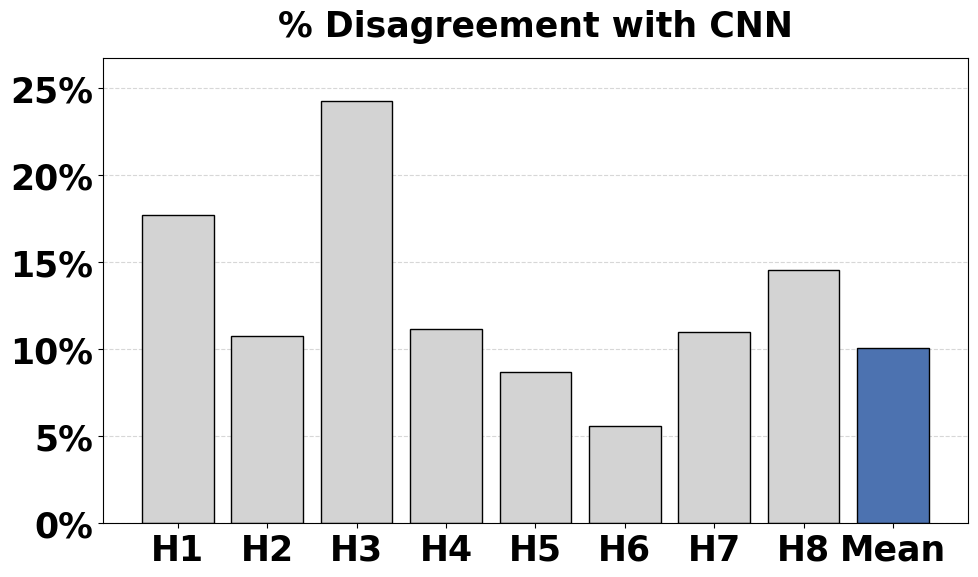

In [6]:
# 4) Compute percent disagreement vs CNN for each human rater AND HumanMean
from matplotlib.ticker import FuncFormatter
percent_disagreement = {}
b = coded['NN']
for r in all_raters + ['HumanMean']:
    a = coded[r]
    mask = (a != -1) & (b != -1)
    if mask.sum() > 0:
        # for HumanMean, round to nearest integer code
        if r == 'HumanMean':
            a_comp = a.round().astype(int)
        else:
            a_comp = a
        pct = 100.0 * (a_comp[mask] != b[mask]).sum() / mask.sum()
    else:
        pct = np.nan
    percent_disagreement[r] = pct

# 5) Create anonymous labels: H1…H9, Mean, CNN (we’ll plot only H1–H9 + Mean)
short_labels = {r: f"H{i+1}" for i, r in enumerate(all_raters)}
short_labels['HumanMean'] = 'Mean'
short_labels['NN'] = 'CNN'

# 6) Prepare data for plotting
plot_order = all_raters + ['HumanMean']   # we omit CNN itself since it's the reference
labels = [short_labels[r] for r in plot_order]
values = [percent_disagreement[r] for r in plot_order]

# 7) Plot bar chart with styling
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, values, edgecolor='black', color='lightgray')

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))

# Highlight the Mean bar in a different shade
bars[-1].set_facecolor('#4C72B0')        # last bar is “Mean”
bars[-1].set_edgecolor('black')

# Axis labels & title
#ax.set_ylabel('% Disagreement with CNN', fontsize=16)
ax.set_title('% Disagreement with CNN', fontsize=25, pad=16, fontweight = 'bold')

# Grid and ticks
ax.set_ylim(0, max(values) * 1.1)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# make tick labels big & bold
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontsize(25
    )         # or whatever size you like
    lbl.set_fontweight('bold')

plt.tight_layout()
plt.savefig('disagreement', dpi = 400)
plt.show()


['AAA' 'AUA' 'UAU' 'UUU' 'UAA' 'UUA' 'AUU' 'AAU']
One A, two U : 299
Two A, one U : 303
Three A     : 3858
Three U     : 797


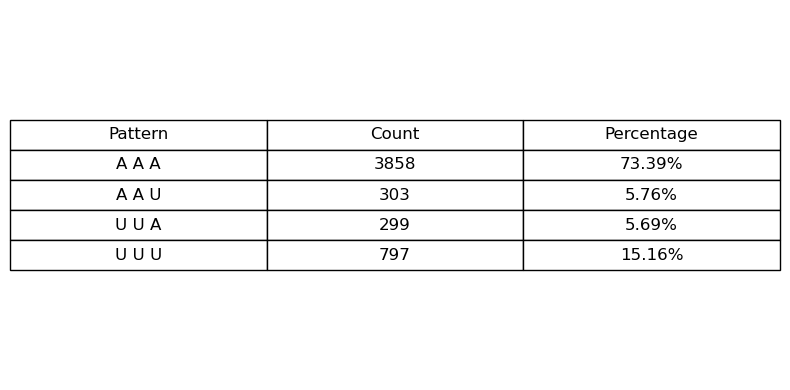

In [18]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
import matplotlib.pyplot as plt

import pandas as pd

# 1) Load your CSV
df = pd.read_csv(r"E:\ArtifactRemovalProject\data\ratings\aggregate_data\aggregated_spectral_ratings.csv")

# 2) Make a short “pattern” code out of the three ratings
#    (A = Acceptable, U = Unacceptable)
df['pattern'] = (
    df['rating_1'].str[0].str.upper() +
    df['rating_2'].str[0].str.upper() +
    df['rating_3'].str[0].str.upper()
)

# Method 1: get a NumPy array of unique values
unique_patterns = df['pattern'].unique()
print(unique_patterns)

# Count how many “A”s are in each pattern
a_counts = df['pattern'].str.count('A')

# Now compute each category
one_A_two_U   = (a_counts == 1).sum()   # 1 A → 2 U
two_A_one_U   = (a_counts == 2).sum()   # 2 A → 1 U
three_A       = (a_counts == 3).sum()   # 3 A → 0 U
three_U       = (a_counts == 0).sum()   # 0 A → 3 U

print(f"One A, two U : {one_A_two_U}")
print(f"Two A, one U : {two_A_one_U}")
print(f"Three A     : {three_A}")
print(f"Three U     : {three_U}")

patterns = ['A A A', 'A A U', 'U U A', 'U U U']
# counts should already be defined
counts = [three_A, two_A_one_U, one_A_two_U, three_U]
total = sum(counts)

patterns = ['A A A', 'A A U', 'U U A', 'U U U']
a_counts = df['pattern'].str.count('A')
counts = [
    (a_counts == 3).sum(),  # AAA
    (a_counts == 2).sum(),  # AAU
    (a_counts == 1).sum(),  # UUA
    (a_counts == 0).sum(),  # UUU
]
total = sum(counts)

# Build summary DataFrame
summary_df = pd.DataFrame({
    'Pattern': patterns,
    'Count': counts,
    'Percentage': [f"{cnt/total*100:.2f}%" for cnt in counts]
})

# Display to user
summary_df


# ─── Render as a Matplotlib table ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')  # hide axes

# draw table
tbl = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='center',
    loc='center'
)

# styling
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1, 1.5)                # stretch rows a bit for readability


plt.tight_layout()
plt.show()

['AAA' 'AUA' 'UAU' 'UUU' 'UAA' 'UUA' 'AUU' 'AAU']
One A, two U : 299
Two A, one U : 303
Three A     : 3858
Three U     : 797
Total: 5257


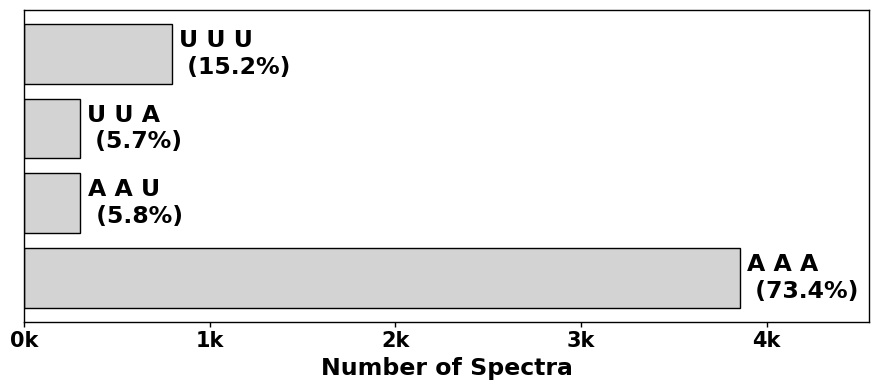

In [2]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
import matplotlib.pyplot as plt

import pandas as pd

# 1) Load your CSV
df = pd.read_csv(r"E:\ArtifactRemovalProject\data\ratings\aggregate_data\aggregated_spectral_ratings.csv")

# 2) Make a short “pattern” code out of the three ratings
#    (A = Acceptable, U = Unacceptable)
df['pattern'] = (
    df['rating_1'].str[0].str.upper() +
    df['rating_2'].str[0].str.upper() +
    df['rating_3'].str[0].str.upper()
)

# Method 1: get a NumPy array of unique values
unique_patterns = df['pattern'].unique()
print(unique_patterns)

# Count how many “A”s are in each pattern
a_counts = df['pattern'].str.count('A')

# Now compute each category
one_A_two_U   = (a_counts == 1).sum()   # 1 A → 2 U
two_A_one_U   = (a_counts == 2).sum()   # 2 A → 1 U
three_A       = (a_counts == 3).sum()   # 3 A → 0 U
three_U       = (a_counts == 0).sum()   # 0 A → 3 U

print(f"One A, two U : {one_A_two_U}")
print(f"Two A, one U : {two_A_one_U}")
print(f"Three A     : {three_A}")
print(f"Three U     : {three_U}")

patterns = ['A A A', 'A A U', 'U U A', 'U U U']
# counts should already be defined
counts = [three_A, two_A_one_U, one_A_two_U, three_U]
total = sum(counts)
print (f"Total: {total}")

offset = max(counts) * 0.01  # 1% of the max, tweak as needed

fig, ax = plt.subplots(figsize=(9,4))
bars = ax.barh(
    patterns,
    counts,
    color='lightgray',
    edgecolor='black',
    linewidth=1
)

# remove the y-ticks (we'll draw our own labels)
ax.set_yticks([])

# annotate each bar: "A A A (xx.x%)"
for bar, pat, cnt in zip(bars, patterns, counts):
    pct = cnt / total * 100
    ax.text(
        cnt + offset,
        bar.get_y() + bar.get_height() / 2,
        f"{pat} \n ({pct:.1f}%)",
        va='center',
        fontweight='bold',
        fontsize=17
    )

# x-axis limits & ticks every 1000 formatted as "0k", "1k", …
ax.set_xlim(0, 4550)
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x/1000)}k"))

# Increase font size of the x-ticks
ax.tick_params(axis='x', labelsize=16)           # <-- make labels bigger
for lbl in ax.get_xticklabels():
    lbl.set_fontweight('bold')    

# bold spines & ticks
for spine in ax.spines.values():
    spine.set_linewidth(1)
ax.tick_params(axis='both', which='major', width=1, labelsize=15)

ax.set_xlabel('Number of Spectra', fontweight='bold', fontsize=17)

plt.tight_layout()

plt.savefig('ratersexpert', dpi = 400)
plt.show()


